# 경기 흐름 예측

## 채권 거래량
금융투자협회 채권정보센터(http://www.kofiabond.or.kr/)

## 회사채 BBB 금리

## KOSPI


In [8]:
%matplotlib inline

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import pickle
import os
from scipy import fftpack
import seaborn as sns

In [10]:
#plt.style.use('default')
#sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_style("dark")

# 채권거래현황

In [11]:
# index_col 로 지정된 열은 Index 형식, datetime 형식으로 변경해야한다.
df=pd.read_excel('data/채권거래현황-v2.xls', thousands=',', index_col=0)
df_bond=df[df[u'구분']==u'거래대금']

df_bond.index=pd.to_datetime(df_bond.index)
df_bond.head()

,구분,국채,지방채,특수채,통안증권,은행채,기타금융채,회사채,ABS,합계
거래일,,,,,,,,,,
2011-07-11,거래대금,154250,139,5600,51380,9076,2022,2162,242,224871
2011-07-12,거래대금,233546,73,10834,98229,18259,3617,4038,1117,369713
2011-07-13,거래대금,181485,584,6958,74104,18474,4208,3871,11,289695
2011-07-14,거래대금,179228,382,4235,66135,22010,3277,2314,1220,278801
2011-07-15,거래대금,135456,142,5728,54936,16173,2291,4904,805,220435


# 채권 금리(최종호가 수익률)

In [12]:
df=pd.read_excel('data/최종호가 수익률-v2.xls', thousands=',', index_col=0)
df_bold_yields=df

df_bold_yields.index=pd.to_datetime(df_bold_yields.index)
df_bold_yields.head()

,국고채권(3년),국고채권(5년),통안증권(1년),회사채(무보증3년)AA-,회사채(무보증3년)BBB-,CD(91일)
일자,,,,,,
2011-07-13,3.71,3.93,3.70,4.42,10.42,3.59
2011-07-14,3.70,3.92,3.70,4.42,10.42,3.59
2011-07-15,3.68,3.89,3.69,4.40,10.40,3.59
2011-07-18,3.69,3.89,3.69,4.40,10.40,3.59
2011-07-19,3.71,3.91,3.69,4.41,10.41,3.59


# Fetch KOSPI from Google

In [13]:
start = datetime.datetime(2011, 7, 11)
end = datetime.datetime(2016, 7, 11)

In [14]:
# Open 	High 	Low 	Close 	Volume
datafilename='data/KOSPI-20110711-20160711.pkl'
df_kospi=None
if os.path.isfile(datafilename):
    fd=open(datafilename)
    df_kospi=pickle.load(fd)
    fd.close()
else:
    df_kospi=web.DataReader("KOSPI", 'google', start, end)
    df_kospi.sort_index()
    output = open('data/KOSPI-20110711-20160711.pkl', 'wb')
    pickle.dump(df_kospi, output)
    output.close()

# Check data

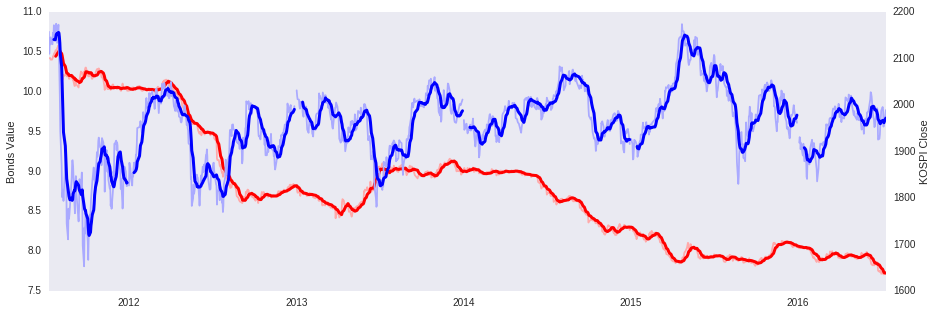

,합계,회사채(무보증3년)BBB-,Close
합계,1.000000,0.088907,-0.066679
회사채(무보증3년)BBB-,0.088907,1.000000,-0.355687
Close,-0.066679,-0.355687,1.000000


In [15]:
#print len(df_bond), len(df_kospi)

sdate=datetime.date(year=2011,month=1,day=1)
edate=datetime.date(year=2016,month=7,day=11)

df=pd.concat([df_bond[u'합계'], df_bold_yields[u'회사채(무보증3년)BBB-'], df_kospi['Close']], axis=1, join_axes=[df_bond.index])
df_merged=df.ix[sdate:edate]

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df_merged[u'회사채(무보증3년)BBB-'], color='#ffaaaa')
ax1.set_ylabel('Bonds Value')
ax1.plot(df_merged[u'회사채(무보증3년)BBB-'].rolling(window=10).mean(), color='r', linewidth=3)
#ax1.legend()
ax2=ax1.twinx()
ax2.plot(df_merged[u'Close'], color='#aaaaff')
ax2.plot(df_merged[u'Close'].rolling(window=10).mean(), color='b', linewidth=3)
ax2.set_ylabel('KOSPI Close')
#ax2.legend()
plt.show()
#abs(df_merged.corr('pearson')) >  0.2
df_merged.corr('pearson')

## 분석

채권가격과 KOSPI 종가는 minus correlation

## Seasonal periodicity

Alias 	Description
B 	business day frequency
C 	custom business day frequency (experimental)
D 	calendar day frequency
W 	weekly frequency
M 	month end frequency
BM 	business month end frequency
CBM 	custom business month end frequency
MS 	month start frequency
BMS 	business month start frequency
CBMS 	custom business month start frequency
Q 	quarter end frequency
BQ 	business quarter endfrequency
QS 	quarter start frequency
BQS 	business quarter start frequency
A 	year end frequency
BA 	business year end frequency
AS 	year start frequency
BAS 	business year start frequency
BH 	business hour frequency
H 	hourly frequency
T, min 	minutely frequency
S 	secondly frequency
L, ms 	milliseconds
U, us 	microseconds
N 	nanoseconds

/home/k/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


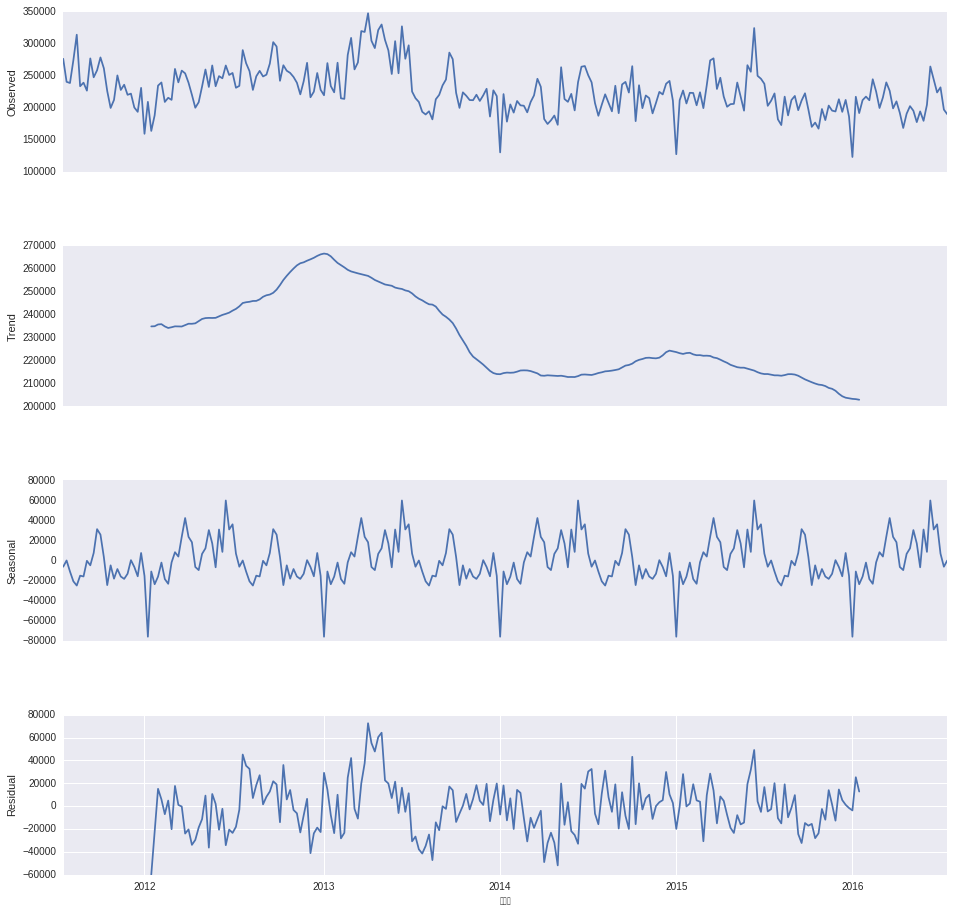

In [16]:
import statsmodels.api as sm

df_season=df_merged
df_season=df_season.drop('Close', axis=1)

# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
df_season = df_season.resample('W').mean()
df_season.head()

flow=df_season[u'합계']
res = sm.tsa.seasonal_decompose(flow)  

#fig,ax = plt.subplots(1,1, figsize=(15,5))  
plt.figure(figsize=(15, 5))
fig = res.plot()
ax = fig.gca()
ax.grid(True)
fig.show()
fig.set_size_inches(15, 15)

In [17]:
seasonal = res.seasonal
print seasonal[abs(seasonal) > 30000]
#easonal.plot(kind='bar')

거래일
2011-09-25    31339.548345
2012-01-08   -76169.605501
2012-03-25    42459.706999
2012-05-13    30416.216614
2012-06-03    30981.807960
2012-06-17    60025.610845
2012-06-24    31034.738249
2012-07-01    36186.964210
2012-09-23    31339.548345
2013-01-06   -76169.605501
2013-03-24    42459.706999
2013-05-12    30416.216614
2013-06-02    30981.807960
2013-06-16    60025.610845
2013-06-23    31034.738249
2013-06-30    36186.964210
2013-09-22    31339.548345
2014-01-05   -76169.605501
2014-03-23    42459.706999
2014-05-11    30416.216614
2014-06-01    30981.807960
2014-06-15    60025.610845
2014-06-22    31034.738249
2014-06-29    36186.964210
2014-09-21    31339.548345
2015-01-04   -76169.605501
2015-03-22    42459.706999
2015-05-10    30416.216614
2015-05-31    30981.807960
2015-06-14    60025.610845
2015-06-21    31034.738249
2015-06-28    36186.964210
2015-09-20    31339.548345
2016-01-03   -76169.605501
2016-03-20    42459.706999
2016-05-08    30416.216614
2016-05-29    30981.8079

## DCT

In [18]:
#coeff=fftpack.dct(df_merged[u'합계'], norm='ortho')
#plt.figure(figsize=(15, 5))
#plt.plot(coeff)
#plt.hist(np.log10(np.abs(coeff)), bins=100, color='#348ABD', alpha=.3, histtype='stepfilled')
